# Description
Obtain the activities of daily life dataset from the UC Irvine machine learning website (https://archive.ics.uci.edu/ml/datasets/Dataset+for+ADL+Recognition+with+Wrist-worn+Accelerometer).
  1. Build a classifier that classifies sequences into one of the 14 activities provided
  2. See if I can improve your classifier by (a) modifying the number of cluster centers in your hierarchical k-means and (b) modifying the size of the fixed length samples that I use.
  
---

# Imports

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import os
from zipfile import ZipFile
import shutil
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

# Data
I'll use the activities of daily life dataset from the UC Irvine machine learning website (https://archive.ics.uci.edu/ml/datasets/Dataset+for+ADL+Recognition+with+Wrist-worn+Accelerometer).
The data was provided by Barbara Bruno, Fulvio Mastrogiovanni and Antonio Sgorbissa

* **Input/Output**: The data includes 14 directories, each of which represents a certain daily activity. There are 839 accelerometer recordings in the dataset, each with 3 columns and some number of rows. The sampling frequency of the device was 32 samples per second.

* **Missing Data**: There is no missing data. However, the data is not very well balanced, and some categories have really small amounts of data.

* **Final Goal**: Build a classifier using vector quantization and other techniques.

## Data loading

In [4]:
# Let's extract the data
with ZipFile('Data/ActivitiesDataset.zip', 'r') as zipObj:
    zipObj.extractall()

In [5]:
# Loading the data into lists of lists
col_labels = ['X','Y','Z']
raw_txt_files = []
activity_labels = ['Liedown_bed', 'Walk', 'Eat_soup', 'Getup_bed', 'Descend_stairs', 
                   'Use_telephone', 'Standup_chair', 'Brush_teeth', 'Climb_stairs', 
                   'Sitdown_chair', 'Eat_meat', 'Comb_hair', 'Drink_glass', 'Pour_water']

for activity in activity_labels:
    activity_txts = []
    for file in os.listdir('./HMP_Dataset/'+activity):
        txtdf = pd.read_csv('./HMP_Dataset/'+activity+'/'+file, names=col_labels,  sep=" ")
        activity_txts.append(txtdf)
    raw_txt_files.append(activity_txts)

In [6]:
# Let's clean up after we're done
shutil.rmtree('./HMP_Dataset')

In [7]:
print('Number of samples for each activity:')
for activity, activity_txts in zip(activity_labels, raw_txt_files):
    print(f'    {activity}: {len(activity_txts)}')
print(f'Total number of samples: {sum(len(activity_txts) for activity_txts in raw_txt_files)}')

Number of samples for each activity:
    Liedown_bed: 28
    Walk: 100
    Eat_soup: 3
    Getup_bed: 101
    Descend_stairs: 42
    Use_telephone: 13
    Standup_chair: 102
    Brush_teeth: 12
    Climb_stairs: 102
    Sitdown_chair: 100
    Eat_meat: 5
    Comb_hair: 31
    Drink_glass: 100
    Pour_water: 100
Total number of samples: 839


## Train-Test Split
It is not wise to out-source this train-test split to traditional sklearn functions as the data is a bit unique (not in a data matrix format), and also balancing the data in the small sample classes requires some delicacy.

In [9]:
test_portion = 0.2

In [10]:
np_random = np.random.RandomState(12345)
train_val_txt_files = []
test_txt_files = []
for _,activity_txt_files in enumerate(raw_txt_files):
    num_txt_files = len(activity_txt_files)
    shuffled_indices = np.arange(num_txt_files)
    np_random.shuffle(shuffled_indices)
    
    train_val_txt_files.append([])
    test_txt_files.append([])
    for i, idx in enumerate(shuffled_indices):
        if i < test_portion * num_txt_files:
            test_txt_files[-1].append(activity_txt_files[idx])
        else:
            train_val_txt_files[-1].append(activity_txt_files[idx])

---

# Training
For now, I'll assume the following two hyper-parameters:
1. `d`: This is the vector quantization length in the number of rows. This default value of 32 corresponds to about 1 full second of observation.
2. `k`: This is the number of K-Means clusters for creating features using cluster histograms.

Since I do not want to engage in any hyper-parameter tuning yet, I will use the whole `train_val_txt_files` data for just training.

In [11]:
d = 32
k = 100
train_txt_files = train_val_txt_files

## Vector-quantization
I wrote a vector-quantization function `quantize` that takes two arguments as input

1. `X`: a numpy array with the shape $(N, 3)$, where $N$ is the number of samples in a single recording. The columns represent the acceleration in each of the $x$, $y$, and $z$ directions. For example, we could have the X matrix as follows
$$X_{135\times 3} = \begin{bmatrix}
x_1 & y_1 & z_1\\
x_2 & y_2 & z_2\\
\cdots\\
x_{135} & y_{135} & z_{135}\\
\end{bmatrix}$$
2. `d`: This is the number of consecutive samples for each segment in the output.

and returns the variable `out`, which arranges the vector into segments of size `d` and drops any incomplete final set of data. For instance, in our previous example we should have
$$\textit{out}_{4\times 96} = 
\begin{bmatrix}
x_1 & y_1 & z_1 & x_2 & y_2 & z_2 & \cdots & x_{32}& y_{32} & z_{32}\\
\cdots\\
x_{97} & y_{97} & z_{97} & x_{98} & y_{98} & z_{98} & \cdots & x_{128}& y_{128} & z_{128}\\
\end{bmatrix}$$
Each row is a segment of 32 consecutive samples (each sample with their corresponding $x_i$, $y_i$, $z_i$ acceleration measurements).

In [12]:
def quantize(X, d=32):
    X_flatten = X.flatten()
    
    columns_count = 3 * d
    rows_count = X_flatten.size // columns_count
    
    out = X_flatten[:rows_count*columns_count].reshape(rows_count, columns_count)

    return out

In [13]:
quantized_data_for_clustering = []
for activity_idx, activity_txt_files in enumerate(train_txt_files):
    for txt_df in activity_txt_files:
        quantized_text = quantize(txt_df.values, d=d)
        quantized_data_for_clustering.append(quantized_text)
quantized_data_for_clustering = np.concatenate(quantized_data_for_clustering, axis=0)

## K-Means clusterer
Using Scikit-learn's KMeans implementation, I will learn a K-Means clusterer. Function `train_kmeans_model` gets the training data `data` and `k` as arguments, and produce a SKLearn's KMeans object with `k` clusters that was trained on `data`.

In [14]:
def train_kmeans_model(data, k):
    kmeans_model = KMeans(n_clusters=k, random_state=12345)
    kmeans_model.fit(data)
    
    return kmeans_model

In [19]:
kmeans_model = train_kmeans_model(quantized_data_for_clustering, k)

## Text to features
Using the `quantize` function I wrote before, the new function `text2hist` converts the data previously obtained from text files into a set of features using the K-Means model I have already trained.

First, quantize the data. This should give me a matrix `quantized_data` with multiple rows which can then be fed to the K-Means clusterer. The output of the K-Means prediction `km_pred` has the same length as the number of rows in `quantized_data`, we should treat it as a set of samples. Then create a normalized count vector of length $k$. For normalization, I consider that the prediction classes range between $0$ and $k-1$ in value. This normalized count vector would be your output. 

The inputs are:
1. `X`: 1. `X`: a numpy array with the shape $(N, 3)$, where $N$ is the number of samples in a single recording. The columns represent the acceleration in each of the $x$, $y$, and $z$ directions. This is the same kind of input that was given to the `quantize` function.
2. `kmeans_model`: This is a trained scikit-learn K-Means object used for prediction.
2. `d`: This is the vector quantization length.
3. `k`: This is the number of clusters.

The output should be a histogram `hist`; A numpy array with the shape of $(k,)$, and non-negative elements that should sum up to 1.

In [20]:
def text2hist(X, kmeans_model, d, k):
    quantized_data = quantize(X, d)
    
    km_pred = kmeans_model.predict(quantized_data)
    
    hist = np.bincount(km_pred, minlength=k) / km_pred.shape[0]    
    hist_sum = np.sum(hist)
    
    hist = hist.astype(np.float64) / hist_sum.astype(np.float64)
    return hist

### Creating features

In [21]:
def feature_maker(txt_files, kmeans_model, d, k):
    features = []
    labels = []
    for activity_idx, activity_txt_files in enumerate(txt_files):
        for txt_df in activity_txt_files:
            feature_vec = text2hist(txt_df.values, kmeans_model, d=d, k=k)
            features.append(feature_vec.reshape(1,-1))
            labels.append(activity_idx)
    features = np.concatenate(features, axis=0)
    labels = np.array(labels)
    return features, labels

In [22]:
train_features, train_labels = feature_maker(train_txt_files, kmeans_model, d, k)

## Training the Classifier
Using Scikit-learn's implementation, I'll train a Random Forest classifier. Function `train_classifier` gets the training data `train_features` and `train_labels` as arguments, and return a SKLearn's `RandomForestClassifier` object that was trained on `data`. I will use 100 trees for building the random forest.

In [23]:
def train_classifier(train_features, train_labels):
    classifier = RandomForestClassifier(n_estimators=100, random_state=12345)
    classifier.fit(train_features, train_labels)
    return classifier

In [25]:
classifier = train_classifier(train_features, train_labels)

In [26]:
train_pred = classifier.predict(train_features)
print(f' Training accuracy: {np.mean(train_pred==train_labels)}')

 Training accuracy: 1.0


In [27]:
test_features, test_labels = feature_maker(test_txt_files, kmeans_model, d, k)
test_pred = classifier.predict(test_features)
print(f' Testing accuracy: {np.mean(test_pred==test_labels)}')

 Testing accuracy: 0.7398843930635838


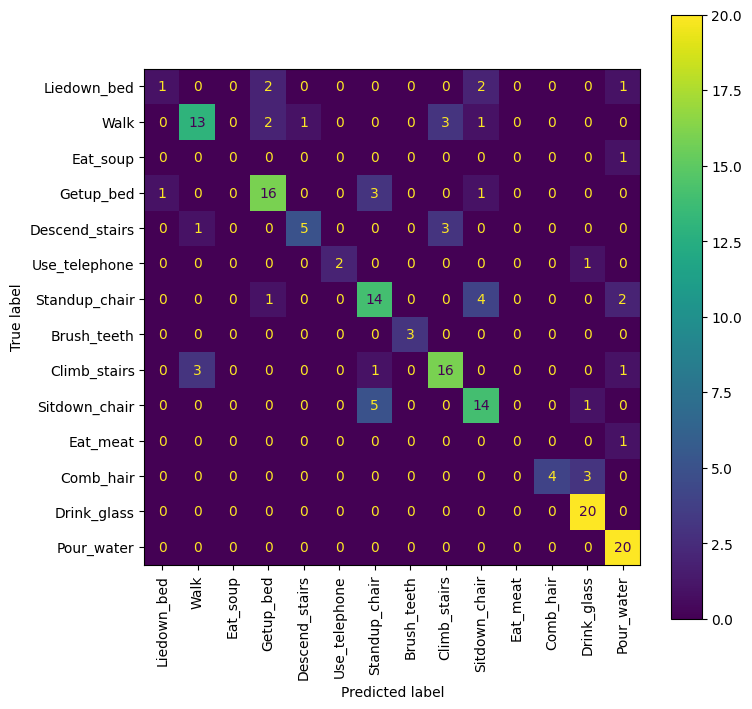

In [28]:
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(8,8), dpi=100)
plot_confusion_matrix(classifier, test_features, test_labels, 
                      display_labels=activity_labels, 
                      xticks_rotation = 'vertical', ax=ax)

# Hyperparameter tuning
The following function only combines what I already have done so far. It essentially takes the training and test data, along with the choice of `d` and `k` hyperparameters, trains a model, and then returns the test accuracy.

In [29]:
def train_and_evaluate(train_txt_files, test_txt_files, d, k, plot_confusion_mat=False):
    quantized_data_for_clustering = []
    for activity_idx, activity_txt_files in enumerate(train_txt_files):
        for txt_df in activity_txt_files:
            quantized_text = quantize(txt_df.values, d=d)
            quantized_data_for_clustering.append(quantized_text)
    quantized_data_for_clustering = np.concatenate(quantized_data_for_clustering, axis=0)

    kmeans_model = train_kmeans_model(quantized_data_for_clustering, k)

    train_features, train_labels = feature_maker(train_txt_files, kmeans_model, d, k)

    classifier = train_classifier(train_features, train_labels)

    test_features, test_labels = feature_maker(test_txt_files, kmeans_model, d, k)
    test_pred = classifier.predict(test_features)
    test_acc = np.mean(test_pred==test_labels)
    
    if plot_confusion_mat:
        fig, ax = plt.subplots(figsize=(8,8), dpi=100)
        plot_confusion_matrix(classifier, test_features, test_labels, 
                              display_labels=activity_labels, 
                              xticks_rotation = 'vertical', ax=ax)
    
    return test_acc

## Cross-Validation

### Getting a dry run
First, let's create a tiny version of our dataset with at most 5 training items per class. Since running a 5 or 10-fold cross-validation would be extremely time consuming, we are running a 3-fold cross-validation.

In [31]:
def generate_cv_pairs(train_val_txt_files, cv_folds=3):
    cross_val_pairs = []
    for fold_idx in range(cv_folds):
        train_cv_files = []
        val_cv_files = []
        for activity_idx, activity_txt_files in enumerate(train_val_txt_files):
            train_cv_files.append([])
            val_cv_files.append([])
            for i, txt_df in enumerate(activity_txt_files):
                if float(fold_idx+1)/cv_folds > float(i)/len(activity_txt_files) >= float(fold_idx)/cv_folds:
                    val_cv_files[-1].append(txt_df)
                else:
                    train_cv_files[-1].append(txt_df)
        cross_val_pairs.append((train_cv_files,val_cv_files))
    return cross_val_pairs

def perform_cross_validation(cross_val_pairs, k_list, d_list):
    kd_acc = dict()
    for k_candidate in k_list:
        for d_candidate in d_list:
            fold_accs = []
            for train_txt_files, val_txt_files in cross_val_pairs:
                print('.', end='')
                fold_acc = train_and_evaluate(train_txt_files, val_txt_files, d_candidate, k_candidate)
                fold_accs.append(fold_acc)
            cv_acc = np.mean(fold_accs)

            kd_acc[(k_candidate, d_candidate)] = cv_acc
        print('')
    return kd_acc

In [32]:
# List of k and d candidates for performing hyper-parameter optimization using Cross-Validation
k_list = [50, 200, 500]
d_list = [8, 16, 32, 64]

In [33]:
train_val_txt_files_tiny = [x[:5] for x in train_val_txt_files]
test_txt_files_tiny = [x[:5] for x in test_txt_files]
cross_val_pairs_tiny = generate_cv_pairs(train_val_txt_files_tiny, cv_folds=3)
kd_acc = perform_cross_validation(cross_val_pairs_tiny, k_list=k_list, d_list=d_list)

............
............
............


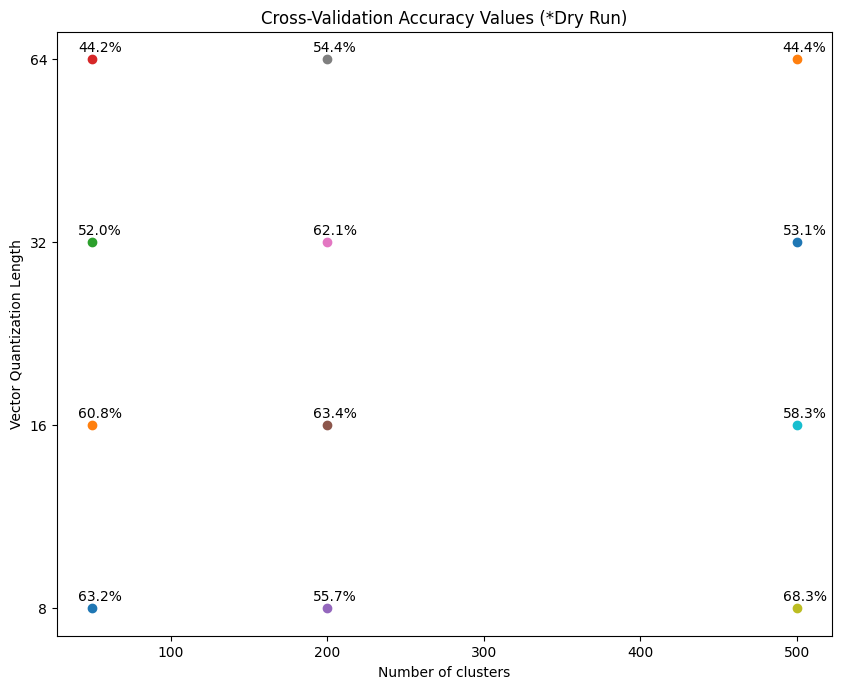

In [34]:
fig, ax = plt.subplots(figsize=(10,8), dpi=100)
for (k_,d_), acc_ in kd_acc.items():
    ax.scatter([k_], [d_])
    ax.annotate('%.1f'%(acc_*100.) + '%', (k_-int((max(k_list)-min(k_list))*0.022), d_*1.03))
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Vector Quantization Length')
ax.set_yscale('symlog', base=2)
ax.set_yticks(d_list)
from matplotlib.ticker import ScalarFormatter
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.ticklabel_format(axis='y', style='plain')
_ = ax.set_title('Cross-Validation Accuracy Values (*Dry Run)')

Best Number of Clusters (*Dry Run): k=500
Best Quantization Length (*Dry Run): d=8
Tuned Test Accuracy (*Dry Run): 0.6379310344827587


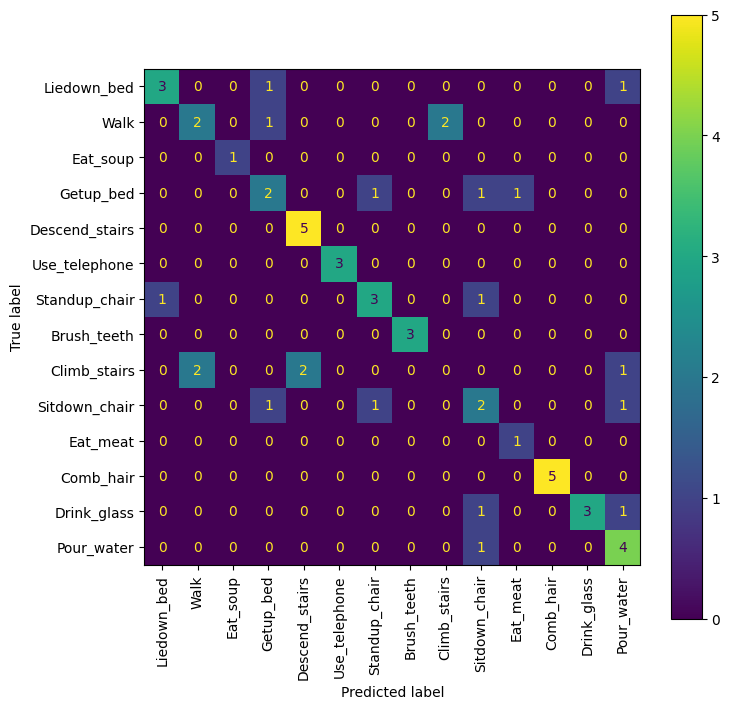

In [35]:
(best_k, best_d), best_cv_acc = max(kd_acc.items(), key=lambda tup_: tup_[1])
test_acc = train_and_evaluate(train_val_txt_files_tiny, test_txt_files_tiny, best_d, best_k, plot_confusion_mat=True)
print(f'Best Number of Clusters (*Dry Run): k={best_k}')
print(f'Best Quantization Length (*Dry Run): d={best_d}')
print(f'Tuned Test Accuracy (*Dry Run): {test_acc}')

### Getting a More Serious Run
Now we will perform cross-validation with the full set of samples.

In [36]:
# List of k and d candidates for performing hyper-parameter optimization using Cross-Validation
k_list = [50, 200, 500]
d_list = [8, 16, 32, 64]

In [37]:
cross_val_pairs = generate_cv_pairs(train_val_txt_files, cv_folds=3)
kd_acc = perform_cross_validation(cross_val_pairs, k_list=k_list, d_list=d_list)

............
............
............


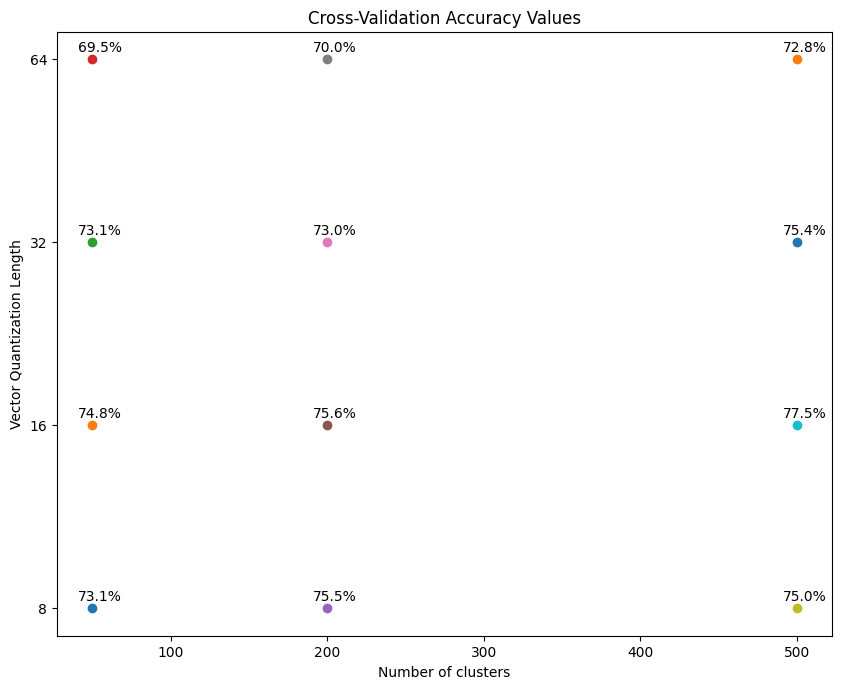

In [38]:
fig, ax = plt.subplots(figsize=(10,8), dpi=100)
for (k_,d_), acc_ in kd_acc.items():
    ax.scatter([k_], [d_])
    ax.annotate('%.1f'%(acc_*100.) + '%', (k_-int((max(k_list)-min(k_list))*0.022), d_*1.03))
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Vector Quantization Length')
ax.set_yscale('symlog', base=2)
ax.set_yticks(d_list)
from matplotlib.ticker import ScalarFormatter
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.ticklabel_format(axis='y', style='plain')
_ = ax.set_title('Cross-Validation Accuracy Values')

Best Number of Clusters: k=500
Best Quantization Length: d=16
Tuned Test Accuracy: 0.7398843930635838


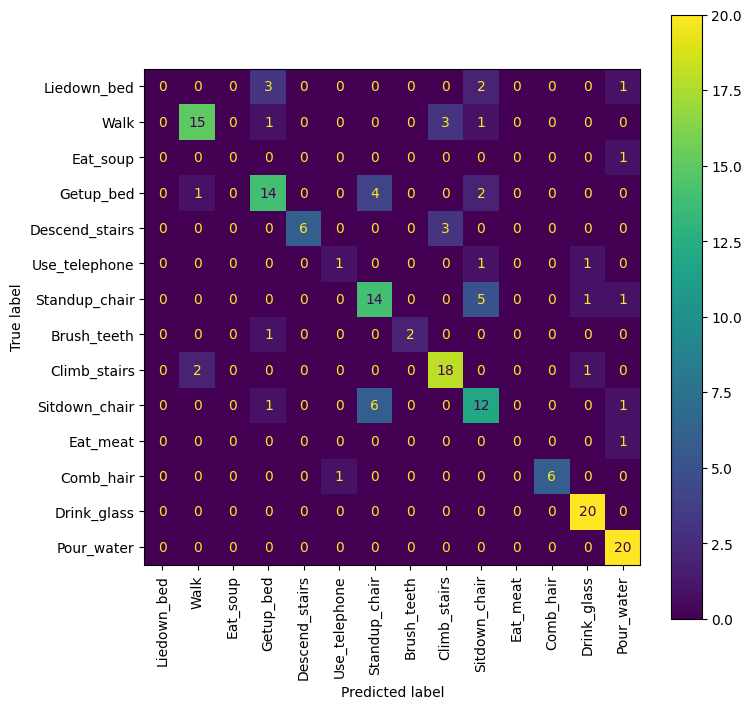

In [39]:
(best_k, best_d), best_cv_acc = max(kd_acc.items(), key=lambda tup_: tup_[1])
test_acc = train_and_evaluate(train_val_txt_files, test_txt_files, best_d, best_k, plot_confusion_mat=True)
print(f'Best Number of Clusters: k={best_k}')
print(f'Best Quantization Length: d={best_d}')
print(f'Tuned Test Accuracy: {test_acc}')